In [1]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from keras.models import Sequential
from sklearn.metrics import silhouette_score

## 1. DATA

#### 1.1 Extract data

In [2]:
df = pd.read_csv("ambient_temperature_system_failure.csv")

#### 1.2 Analyze data

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


In [4]:
# check the timestamp format and frequence 
print(df['timestamp'].head())

0    2013-07-04 00:00:00
1    2013-07-04 01:00:00
2    2013-07-04 02:00:00
3    2013-07-04 03:00:00
4    2013-07-04 04:00:00
Name: timestamp, dtype: object


In [5]:
# check the temperature mean
print(df['value'].mean())

71.24243270828815


<Axes: xlabel='timestamp'>

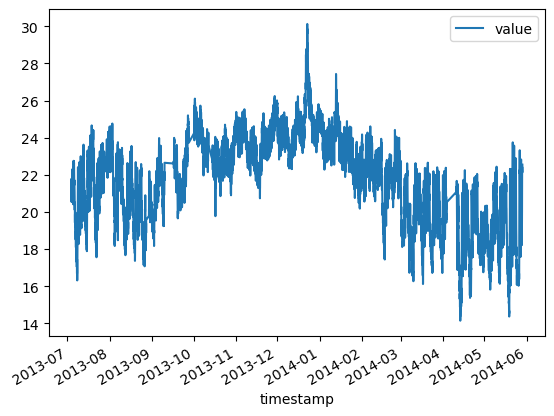

In [6]:
# change the type of timestamp column for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
# change fahrenheit to °C (temperature mean= 71 -> fahrenheit)
df['value'] = (df['value'] - 32) * 5/9
# plot the data
df.plot(x='timestamp', y='value')

#### Feature engineering

In [7]:
# Add two columns 'hours' and 'daylight' to record the hour of the day and to indicate if it's daytime or not
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01

In [8]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [9]:
# Convert timestamp to date format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract quarter information and store it in another column 'quarter'
df['quarter'] = df['timestamp'].dt.to_period('Q').astype(str).str[-1:]
df['quarter'] = pd.to_numeric(df['quarter'])

# Display the DataFrame with the new 'quarter' column
print(df[['timestamp', 'quarter']])

               timestamp  quarter
0    2013-07-04 00:00:00        3
1    2013-07-04 01:00:00        3
2    2013-07-04 02:00:00        3
3    2013-07-04 03:00:00        3
4    2013-07-04 04:00:00        3
...                  ...      ...
7262 2014-05-28 11:00:00        2
7263 2014-05-28 12:00:00        2
7264 2014-05-28 13:00:00        2
7265 2014-05-28 14:00:00        2
7266 2014-05-28 15:00:00        2

[7267 rows x 2 columns]


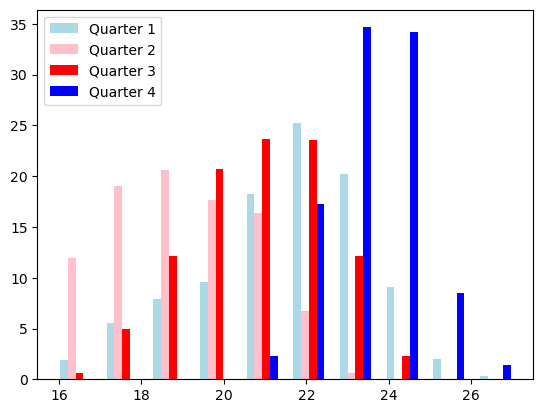

In [10]:
# Create a histogram plot to check the frequency of temperature quarter-wise
a = df.loc[df['quarter'] == 1, 'value']
b = df.loc[df['quarter'] == 2, 'value']
c = df.loc[df['quarter'] == 3, 'value']
d = df.loc[df['quarter'] == 4, 'value']

fig, ax = plt.subplots()
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='lightblue', label='Quarter 1')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='pink', label ='Quarter 2')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='Quarter 3')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='blue', label ='Quarter 4')

plt.legend()

From the above plot, we can conclude that towards the end of the year the temperature rises.

## 2. Models

#### 2.1 Cluster only

Use for collective anomalies (unordered).

We group together the usual combination of features. The points that are far from the cluster are points with usual combination of features.We consider those points as anomalies.

In [11]:
# Using PCA, scale the model to 2 important features
data = df[['value', 'hours', 'daylight', 'quarter']]
scaler = preprocessing.StandardScaler()

np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)

np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

C:\Users\meghn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\meghn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\meghn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\meghn\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

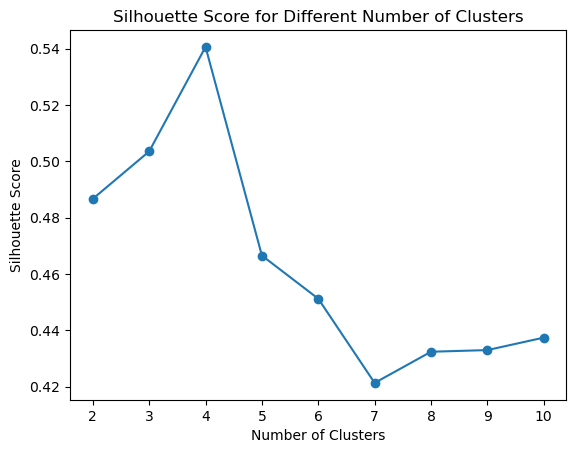

Optimal Number of Clusters: 4


In [12]:
# Range of possible number of clusters
n_clusters_range = range(2, 11)
kmeans_models=[]
silhouette_scores = []

# Fit KMeans models and calculate silhouette scores for each number of clusters
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_models.append(kmeans)
    kmeans.fit(data)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(data, labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores for different number of clusters
plt.plot(n_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Number of Clusters')
plt.show()

# Find the optimal number of clusters with the highest silhouette score
optimal_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
print(f'Optimal Number of Clusters: {optimal_n_clusters}')


In [13]:
kmeans_models

[KMeans(n_clusters=2, random_state=42),
 KMeans(n_clusters=3, random_state=42),
 KMeans(n_clusters=4, random_state=42),
 KMeans(n_clusters=5, random_state=42),
 KMeans(n_clusters=6, random_state=42),
 KMeans(n_clusters=7, random_state=42),
 KMeans(random_state=42),
 KMeans(n_clusters=9, random_state=42),
 KMeans(n_clusters=10, random_state=42)]

In [14]:
df['cluster'] = kmeans_models[2].predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

1    3037
2    2112
0    1286
3     832
Name: cluster, dtype: int64

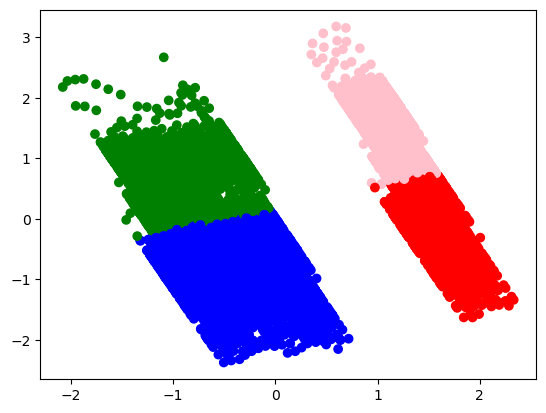

In [15]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [16]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa - Xb)
    return distance

# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data, kmeans_models[2])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

C:\Users\meghn\AppData\Local\Temp\ipykernel_13632\2919291565.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series()


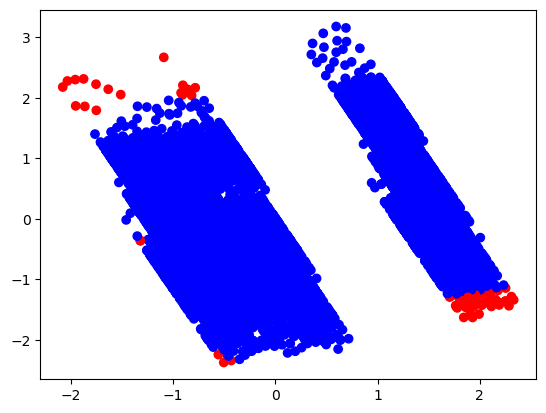

In [17]:
# Visualisation of anomaly
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

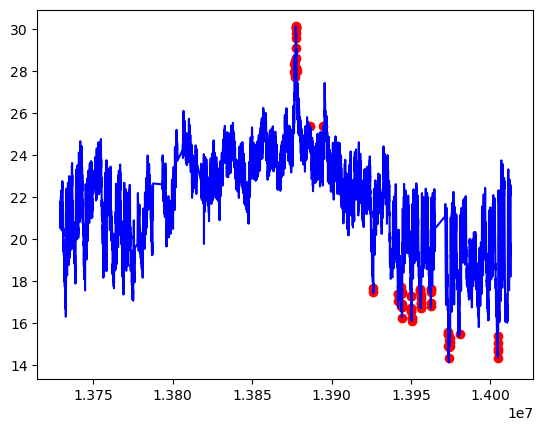

In [18]:
# Visualisation of anomaly with time
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

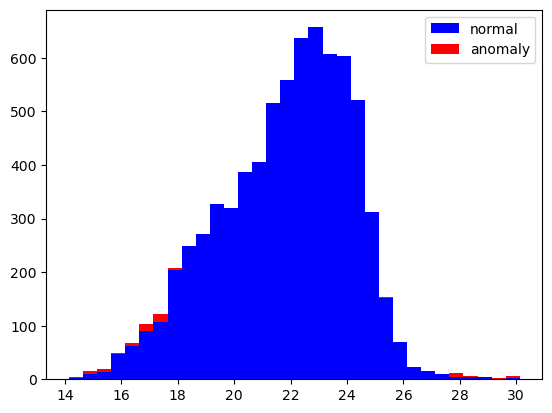

In [19]:
# Visualisation of anomaly with time (histogram)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Cluster method detects the low temperature around the end of record as unusually low. It doesn't detect the highest temperature pic.

#### 2.2 Categories + Gaussian

Use for contextual data and collective anomalies (unordered).

We will separate data by quarter. Then we find outliers (gaussian repartition, unimodal) by categories independently.


In [20]:
# creation of 4 differents data set based on 'quarter' column
df_class0 = df.loc[df['quarter'] == 1, 'value']
df_class1 = df.loc[df['quarter'] == 2, 'value']
df_class2 = df.loc[df['quarter'] == 3, 'value']
df_class3 = df.loc[df['quarter'] == 4, 'value']

<Axes: >

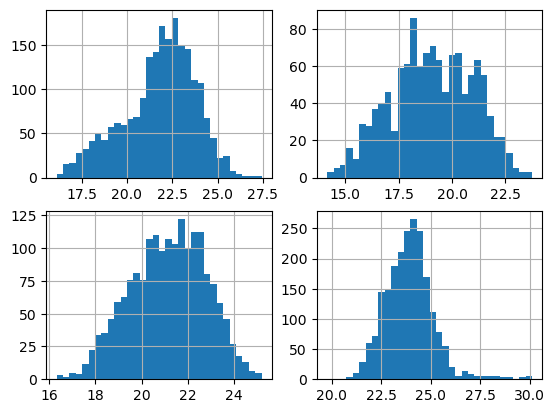

In [21]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [22]:
# apply gaussian distribution to find outliers in each categories

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

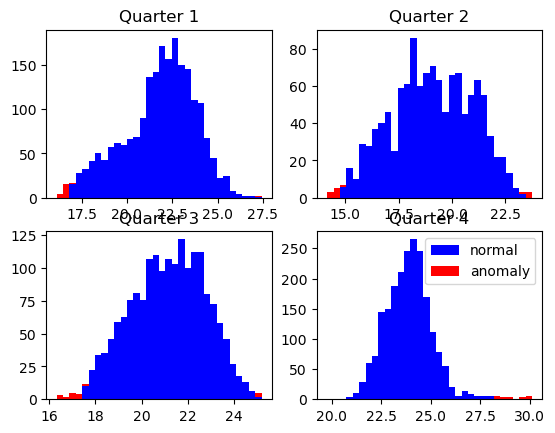

In [23]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'value']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'value']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'value']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'value']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'value']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'value']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'value']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("Quarter 1")
axs[0,1].set_title("Quarter 2")
axs[1,0].set_title("Quarter 3")
axs[1,1].set_title("Quarter 4")
plt.legend()
plt.show()

In [24]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int) 

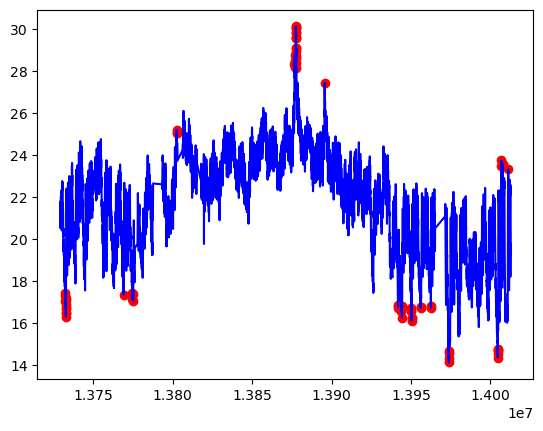

In [25]:
# visualisation of anomaly throughout time (viz 1)
fig, ax = plt.subplots()

a = df.loc[df['anomaly22'] == 1, ('time_epoch', 'value')] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

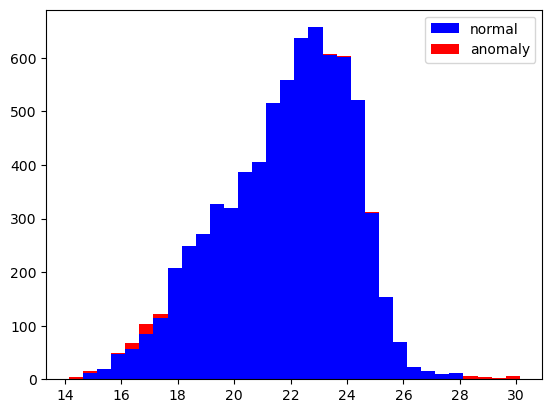

In [26]:
# visualisation of anomaly with temperature repartition
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

This method also detects anomalies at both ends of the records.

#### 2.3 Isolation Forest

Use for collective anomalies (unordered).

Simple, works well with different data repartition and efficient with high dimention data.

In [27]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight','quarter']]
scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

# Fit isolation forest model
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
df['anomaly23'] = pd.Series(model.predict(data))
df['anomaly23'] = df['anomaly23'].map( {1: 0, -1: 1} )
print(df['anomaly23'].value_counts())

0    7194
1      73
Name: anomaly23, dtype: int64


In [28]:
df.head()

,timestamp,value,hours,daylight,time_epoch,quarter,cluster,principal_feature1,principal_feature2,anomaly21,anomaly22,anomaly23
0,2013-07-04 00:00:00,21.044908,0,0,13728960,3,0,1.615635,0.651158,0,0,0
1,2013-07-04 01:00:00,21.789015,1,0,13728996,3,3,1.469508,0.799714,0,0,0
2,2013-07-04 02:00:00,21.598781,2,0,13729032,3,3,1.411769,0.729880,0,0,0
3,2013-07-04 03:00:00,20.533000,3,0,13729068,3,0,1.436855,0.455398,0,0,0
4,2013-07-04 04:00:00,20.713084,4,0,13729104,3,0,1.344084,0.472121,0,0,0


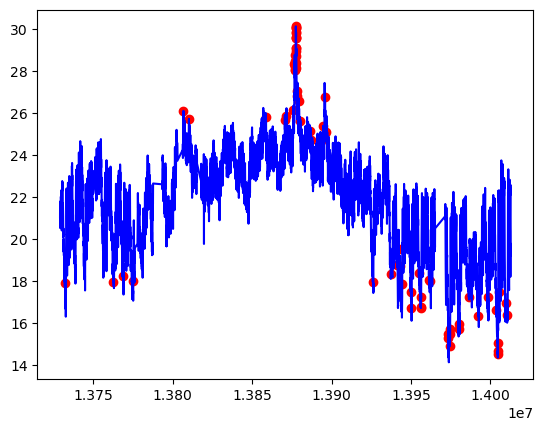

In [29]:
# Visualisation of anomaly with time
fig, ax = plt.subplots()

a = df.loc[df['anomaly23'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

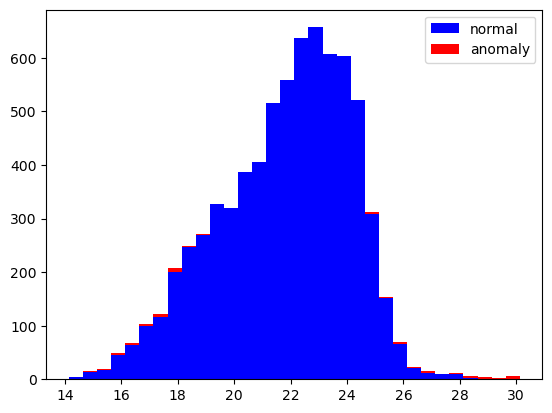

In [30]:
# Visualisation of anomaly with temperature
a = df.loc[df['anomaly23'] == 0, 'value']
b = df.loc[df['anomaly23'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

Isolation forest model detects anomalies throughout the temperature ranges

#### 2.4 One class SVM

Use for collective anomalies (unordered).

Good for novelty detection (no anomalies in the train set). This algorithm performs well for multimodal data.

In [31]:
# Take useful feature and standardize them 
data = df[['value', 'hours', 'daylight', 'quarter']]
scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(data)

# Fit one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)

# add the data to the main  
df['anomaly24'] = pd.Series(model.predict(data))
df['anomaly24'] = df['anomaly24'].map( {1: 0, -1: 1} )
print(df['anomaly24'].value_counts())

0    7194
1      73
Name: anomaly24, dtype: int64


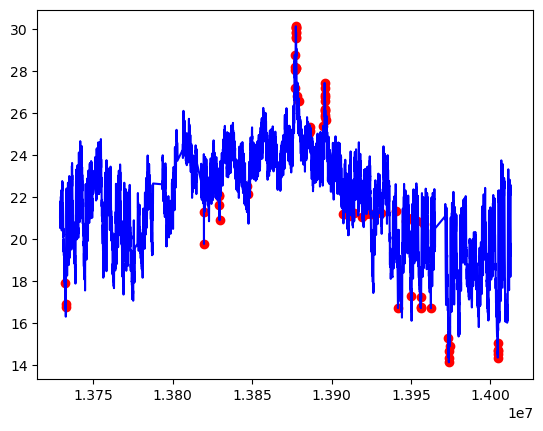

In [32]:
# Visualisation of anomaly with time
fig, ax = plt.subplots()

a = df.loc[df['anomaly24'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

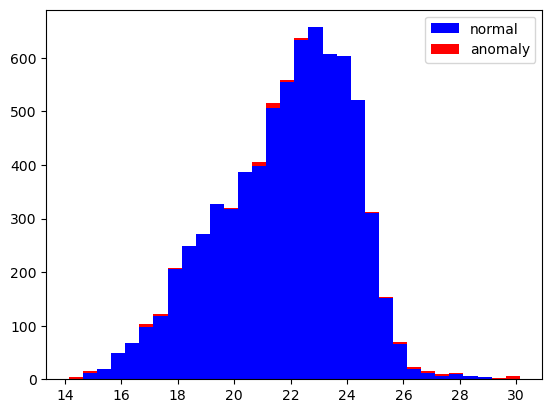

In [33]:
# Visualisation of anomaly with temperature
a = df.loc[df['anomaly24'] == 0, 'value']
b = df.loc[df['anomaly24'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Give result similar to isolation forest and finds anomalies throughout the range.